In [ ]:
import cftime 
import nc_time_axis
from concurrent.futures import ProcessPoolExecutor
import random
random.seed(42)

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter) 
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats 
             
from src import utils, models, cesm_utils, ttp, plots

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
# List of CESM2 Ensemble Members
ensemble_members = models.CESM2_ensemble_members # List of CESM2 Ensemble Members

In [ ]:
# For each ensemble member, get timeseries of global maps (see data_processing.ipynb)
cesm_global_djf_sst_map = cesm_utils.process_cesm_ensemble(ensemble_members, "SST.global.1900_2100")  # annual global DJF ssts
cesm_global_djf_sst_map = cesm_global_djf_sst_map['SST'].sel(time=slice('1900', '2014'))

cesm_global_mam_prect_map = cesm_utils.process_cesm_ensemble(ensemble_members, "PRECT.msea.MAM.1900_2100") 
cesm_global_mam_prect_map = cesm_global_mam_prect_map['PRECT'].sel(time=slice('1900', '2014')) # says msea but is global
mam_seconds_per_month = (31 * 24 * 60 * 60 + 30 * 24 * 60 * 60 + 31 * 24 * 60 * 60)/3
cesm_global_mam_prect_map = cesm_global_mam_prect_map * 1000 * mam_seconds_per_month #m/s to mm/month

cesm_global_mam_tmq_map = cesm_utils.process_cesm_ensemble(ensemble_members, "TMQ.MAM.1900_2100")
cesm_global_mam_tmq_map = cesm_global_mam_tmq_map['TMQ'].sel(time=slice('1900', '2014'))

cesm_tropics_djf_omega_xsec = cesm_utils.process_cesm_ensemble(ensemble_members, "OMEGA.tropics.DJF.1900_2100")
cesm_tropics_djf_omega_xsec = cesm_tropics_djf_omega_xsec['OMEGA'].sel(time=slice('1900', '2014'))

cesm_global_djf_u850_map = cesm_utils.process_cesm_ensemble(ensemble_members, "U850.DJF.1900_2100")
cesm_global_djf_u850_map = cesm_global_djf_u850_map['U'].sel(time=slice('1900', '2014'))

cesm_global_djf_v850_map = cesm_utils.process_cesm_ensemble(ensemble_members, "V850.DJF.1900_2100")
cesm_global_djf_v850_map = cesm_global_djf_v850_map['V'].sel(time=slice('1900', '2014'))

In [4]:
TTP_index = ttp.get_interbasin_timeseries_modified(cesm_global_djf_sst_map, detrend=False,
                          base_start='1951-01', base_end='2015-12',
                          filtered=True)

In [5]:
pTTP_df, nTTP_df = ttp.find_positive_negative_periods(TTP_index)
random_len_pTTP_df, random_len_nTTP_df = ttp.select_random_periods(TTP_index)

dataframe_categories = [pTTP_df, nTTP_df, random_len_pTTP_df, random_len_nTTP_df]

In [6]:
def get_field_difference(field):
    """Calculate pTTP/nTTP fields relative to random."""
    
    pTTP_field, nTTP_field, random_len_pTTP, random_len_nTTP = utils.select_field_quartiles(
        field, dataframe_categories

    )

    def get_difference_and_pval(selected_data, random_data):
        difference = selected_data.mean(dim='random') - random_data.mean(dim=['random'])
        tstat, pval = stats.ttest_ind(selected_data, random_data, equal_var=False)
        pval = utils.correct_pvals(pval, alpha_global=0.01, method='fdr_bh')
        return difference, pval
    
    pTTP_diff, pTTP_pval = get_difference_and_pval(pTTP_field, random_len_pTTP)
    nTTP_diff, nTTP_pval = get_difference_and_pval(nTTP_field, random_len_nTTP)

    return pTTP_diff, pTTP_pval, nTTP_diff, nTTP_pval

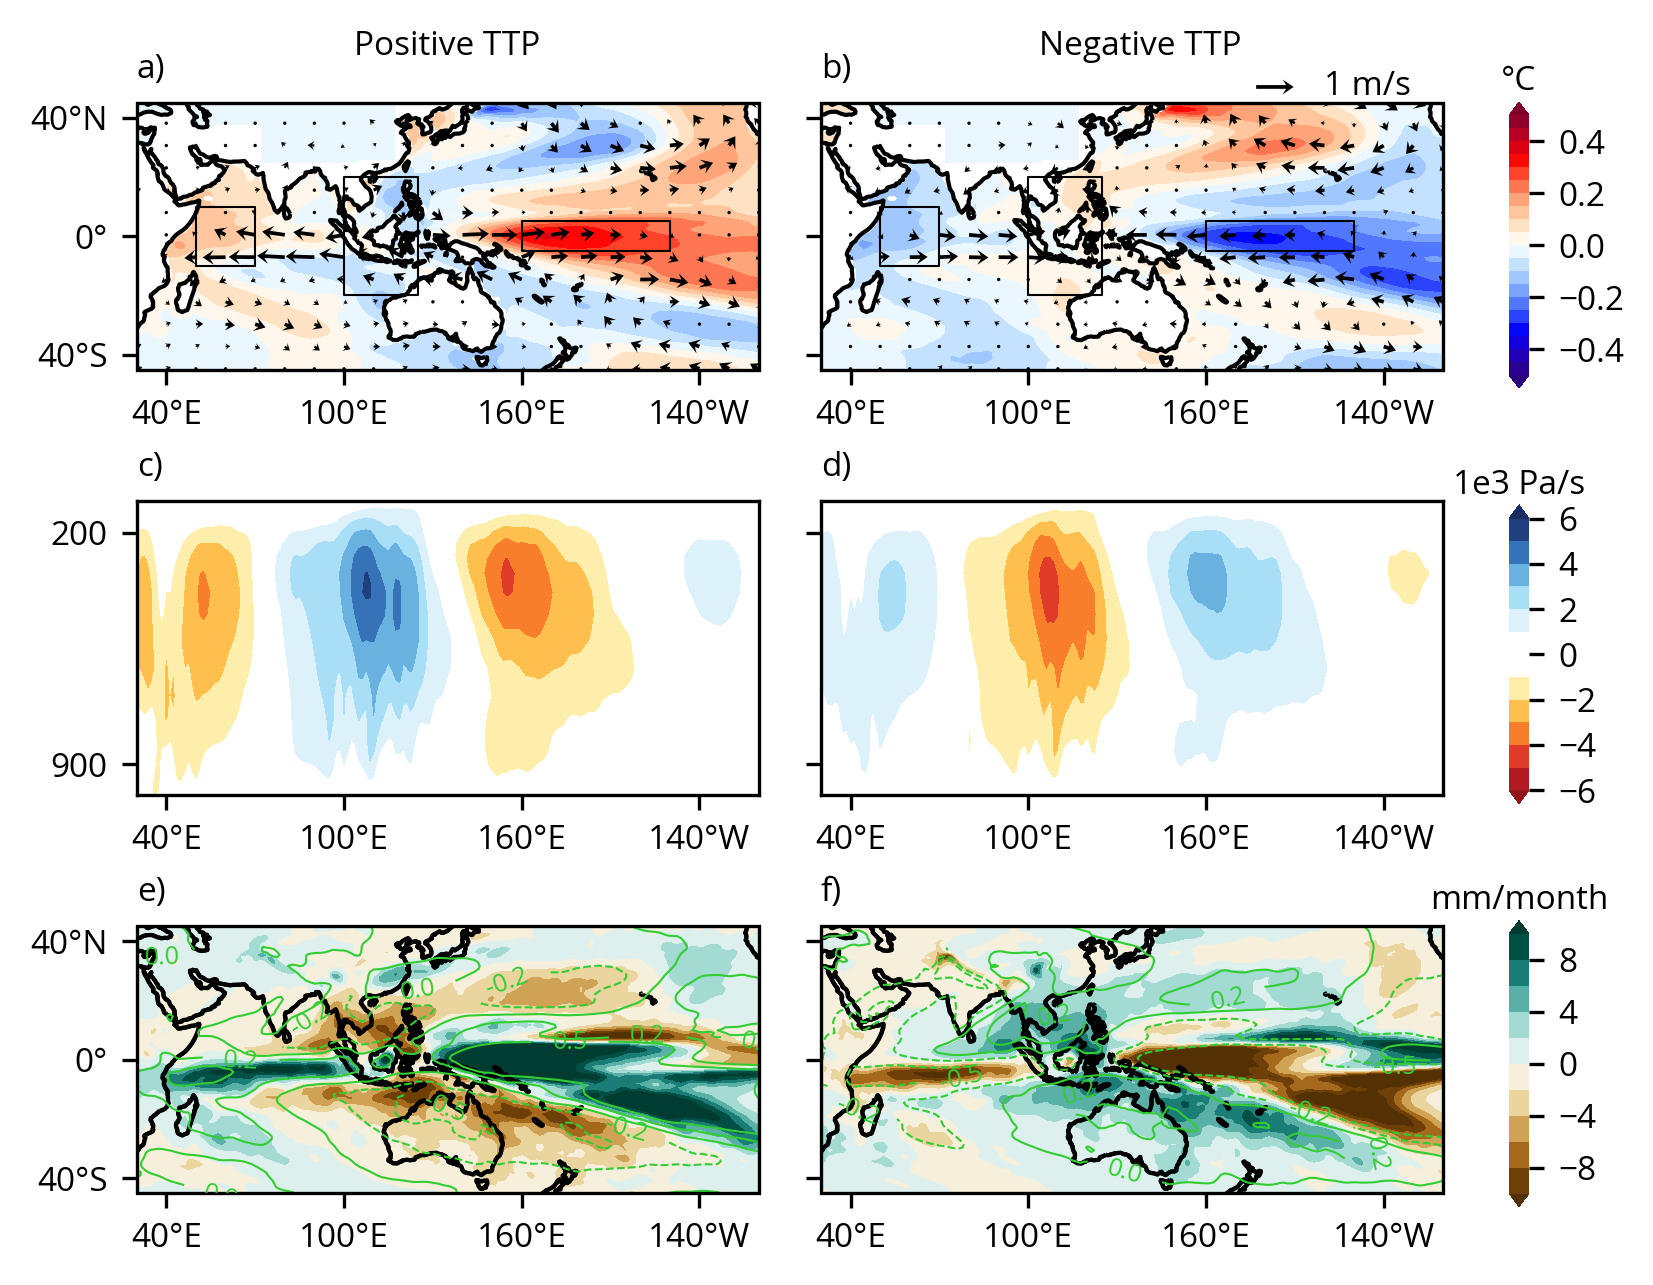

In [7]:
mpl.rcParams['hatch.linewidth'] = 0.3
utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

# Figure dimensions
fig_width_cm = 14
fig_height_cm = 11
fig_size_in = (fig_width_cm / 2.54, fig_height_cm / 2.54)

fig = plt.figure(figsize=fig_size_in, dpi=300, constrained_layout=True)
gs1 = GridSpec(3, 2, top=0.93, bottom=0.07, left=0.08, right=0.87, hspace=0.4, wspace=0.1)
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs1[1, 0])
ax4 = fig.add_subplot(gs1[1, 1])
ax5 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax6 = fig.add_subplot(gs1[2, 1], projection=ccrs.PlateCarree(central_longitude=180))

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

# Data processing
pTTP_diff_sst, pTTP_pval_sst, nTTP_diff_sst, nTTP_pval_sst = get_field_difference(cesm_global_djf_sst_map)
pTTP_diff_u, pTTP_pval_u, nTTP_diff_u, nTTP_pval_u = get_field_difference(cesm_global_djf_u850_map)
pTTP_diff_v, pTTP_pval_v, nTTP_diff_v, nTTP_pval_v = get_field_difference(cesm_global_djf_v850_map)
pTTP_diff_omega, pTTP_pval_omega, nTTP_diff_omega, nTTP_pval_omega = get_field_difference(cesm_tropics_djf_omega_xsec)
pTTP_diff_prect, pTTP_pval_prect, nTTP_diff_prect, nTTP_pval_prect = get_field_difference(cesm_global_mam_prect_map)
pTTP_diff_tmq, pTTP_pval_tmq, nTTP_diff_tmq, nTTP_pval_tmq = get_field_difference(cesm_global_mam_tmq_map)

# Format map axes
def format_map_ax(ax):
    ax.set_extent([30, 240, -45, 45], crs=ccrs.PlateCarree())
    ax.set_xticks([40, 100, 160, 220], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks([-40, 0, 40], crs=ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines(linewidth=1)

############## Figure 3a and 3b ##############
im1, q1 = plots.plot_sst_wind(ax1, pTTP_diff_sst, pTTP_diff_u, pTTP_diff_v)
im2, q2 = plots.plot_sst_wind(ax2, nTTP_diff_sst, nTTP_diff_u, nTTP_diff_v)

# Add quiver key to ax2
ax2.quiverkey(
    q2, X=0.76, Y=1.06, U=1,
    label='1 m/s', labelpos='E', fontproperties={'size': 8}
)

# Add TTP boxes to ax1 and ax2
for ax in [ax1, ax2]:
    plots.add_rectangles(ax)

# Add colorbar for Figures 3a and 3b
cbar_ax1 = fig.add_axes([0.91, 0.70, 0.012, 0.22]) # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, cax=cbar_ax1, ticks=[-0.4, -0.2, 0, 0.2, 0.4])
cbar1.outline.set_visible(False)
cbar1.ax.set_title('°C', fontsize=8)

############## Figure 3c and 3d ##############
om1 = plots.plot_omega(ax3, pTTP_diff_omega)
om2 = plots.plot_omega(ax4, nTTP_diff_omega)

# Set x and y ticks for ax3 and ax4
for ax in [ax3, ax4]:
    ax.set_xticks([40, 100, 160, 220])
    ax.set_xticklabels(['40°E', '100°E', '160°E', '140°W'], fontsize=8)
    ax.set_yticks([200, 900])
    if ax == ax3:
        ax.set_yticklabels(['200', '900'], fontsize=8)
    else:
        ax.set_yticklabels([])

# Add colorbar for Figures 3c and 3d
cbar_ax2 = fig.add_axes([0.91, 0.38, 0.012, 0.23]) # [left, bottom, width, height]
cbar2 = fig.colorbar(om1, cax=cbar_ax2, ticks=[-6, -4, -2, 0, 2, 4, 6])
cbar2.outline.set_visible(False)
cbar2.ax.set_title('1e3 Pa/s', fontsize=8)

############## Figure 3e and 3f ##############
pc1 = plots.plot_prect_tmq(ax5, pTTP_diff_prect, pTTP_diff_tmq)
pc2 = plots.plot_prect_tmq(ax6, nTTP_diff_prect, nTTP_diff_tmq)

# Add colorbar for Figures 3e and 3f
cbar_ax3 = fig.add_axes([0.91, 0.07, 0.012, 0.22]) # [left, bottom, width, height]
cbar3 = fig.colorbar(pc1, cax=cbar_ax3)
cbar3.outline.set_visible(False)
cbar3.ax.set_title('mm/month', fontsize=8)

# Add coastlines to ax5 and ax6
for ax in [ax5, ax6]:
    ax.coastlines(linewidth=1)

############################################

# Format map axes
for ax in [ax1, ax2, ax5, ax6]:
    format_map_ax(ax)
for ax in [ax2, ax6]:
    ax.set_yticklabels([])

# Set subplot labels
titles = ["a)", "b)", "c)", "d)", "e)", "f)"]
for i, (ax, title) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6], titles)):
    ax.set_title(title, loc="left", fontsize=8)

# Add main titles to ax1 and ax2
ax1.text(0.35, 1.18, 'Positive TTP', transform=ax1.transAxes, fontsize=8)
ax2.text(0.35, 1.18, 'Negative TTP', transform=ax2.transAxes, fontsize=8)

# Adjust layout and save figures
plt.tight_layout()
plt.savefig("Fig3.png")
plt.savefig("Fig3.pdf")
